### Packages

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType

In [3]:
import pandas as pd
%matplotlib inline

### SparkContext

In [4]:
# Create SparkContext object with 4 executors. It is the delegate between head and executors
sc = SparkContext(master="local[4]")

# Create SQLContext similar to SparkContext to use sql
sqc = SQLContext(sc)

In [5]:
print(sc, sqc)
#sc.stop() ; # to stop context. Do this before starting new one. Only 1 at a time

<SparkContext master=local[4] appName=pyspark-shell> <pyspark.sql.context.SQLContext object at 0x7f427d0a5518>


In [6]:
sc.version

'2.2.1'

### Download data

In [7]:
# Download from 
url = "https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz"
# to
data_dir = './data/weather'
data_file = './data/weather/NY.tgz'
data_file_parquet = './data/weather/NY.parquet'

In [8]:
from os.path import split,join,exists

# mkdir
if exists(data_dir):
    print(data_dir," dir exists")
else:
    print("creating dir: ", data_dir)
    mkdir(data_dir)

# get file
if exists(data_file):
    print(data_file," file exists")
else:
    command="wget %s -P %s "%(url, data_dir)
    print(command)
    !$command
    
!ls -lh $data_file

# untar it
if exists(data_file_parquet):
    print(data_file_parquet," dir exists")
else:
    !tar xzvf $data_file -C $data_dir

./data/weather  dir exists
./data/weather/NY.tgz  file exists
-rw-rw-r-- 1 sb sb 64M Apr 18 18:12 ./data/weather/NY.tgz
./data/weather/NY.parquet  dir exists


### Load data

In [9]:
# Read file
df = sqc.read.load(data_file_parquet)
print(type(df))
df.show(1)

<class 'pyspark.sql.dataframe.DataFrame'>
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 1 row



### Dataframe operations

#### Basic dataframe ops

In [10]:
# Pick few columns
df1 = df.select('Station','Measurement','Year','Values','State')
df1.show(5)

+-----------+-----------+----+--------------------+-----+
|    Station|Measurement|Year|              Values|State|
+-----------+-----------+----+--------------------+-----+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|   NY|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|   NY|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|   NY|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|   NY|
|USW00094704|   PRCP_s20|1949|[BB 49 BC 49 BD 4...|   NY|
+-----------+-----------+----+--------------------+-----+
only showing top 5 rows



In [11]:
# Number of entries
df1.count()

168398

In [12]:
# count, mean, std, min, max
df1.describe().select('Station','Measurement').show()

+-----------+-----------+
|    Station|Measurement|
+-----------+-----------+
|     168398|     168398|
|       null|       null|
|       null|       null|
|USC00300015|       PRCP|
|USW00094794|   TOBS_s20|
+-----------+-----------+



In [13]:
# Print schema
df1.printSchema()

root
 |-- Station: string (nullable = true)
 |-- Measurement: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Values: binary (nullable = true)
 |-- State: string (nullable = true)



In [14]:
# Aggregrate (min , count) of df columns
df1.groupby('measurement').agg({'Year':'min', 'Station':'count'}).show()

+-----------+--------------+---------+
|measurement|count(Station)|min(Year)|
+-----------+--------------+---------+
|   TMIN_s20|         13442|     1873|
|       TMIN|         13442|     1873|
|   SNOW_s20|         15629|     1884|
|       TOBS|         10956|     1876|
|   SNWD_s20|         14617|     1888|
|   PRCP_s20|         16118|     1871|
|   TOBS_s20|         10956|     1876|
|       TMAX|         13437|     1873|
|       SNOW|         15629|     1884|
|   TMAX_s20|         13437|     1873|
|       SNWD|         14617|     1888|
|       PRCP|         16118|     1871|
+-----------+--------------+---------+



In [15]:
# Display rows
df1.show(5)

+-----------+-----------+----+--------------------+-----+
|    Station|Measurement|Year|              Values|State|
+-----------+-----------+----+--------------------+-----+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|   NY|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|   NY|
|USW00094704|   PRCP_s20|1947|[79 4C 75 4C 8F 4...|   NY|
|USW00094704|   PRCP_s20|1948|[72 48 7A 48 85 4...|   NY|
|USW00094704|   PRCP_s20|1949|[BB 49 BC 49 BD 4...|   NY|
+-----------+-----------+----+--------------------+-----+
only showing top 5 rows



#### Imperative manipulation: (Python style)

In [16]:
# Specify what we want and how we want. Order of operations is specified 

In [17]:
# Get 5 measurements with highest counts
cnt_list = df1.groupby('measurement').count().collect()
print(type(cnt_list), len(cnt_list))
cnt_list

<class 'list'> 12


[Row(measurement='TMIN_s20', count=13442),
 Row(measurement='TMIN', count=13442),
 Row(measurement='SNOW_s20', count=15629),
 Row(measurement='TOBS', count=10956),
 Row(measurement='SNWD_s20', count=14617),
 Row(measurement='PRCP_s20', count=16118),
 Row(measurement='TOBS_s20', count=10956),
 Row(measurement='TMAX', count=13437),
 Row(measurement='SNOW', count=15629),
 Row(measurement='TMAX_s20', count=13437),
 Row(measurement='SNWD', count=14617),
 Row(measurement='PRCP', count=16118)]

In [18]:
# Sort and get highest counts
el_tuples = [(el['measurement'], el['count']) for el in cnt_list]
el_tuples.sort(key = lambda tup: tup[1])
[x for x in reversed(el_tuples[-5:])]

[('PRCP', 16118),
 ('PRCP_s20', 16118),
 ('SNOW', 15629),
 ('SNOW_s20', 15629),
 ('SNWD', 14617)]

#### Declarative manipulation: (SQL style)

In [19]:
# Specify only what we want. Some operations may not be there.
# Need to register df as table

In [20]:
# Read sample datafile
!ls data/people.json
fpath = 'data/people.json'
df = sqc.read.json(fpath)
df.show()

# Register df as temp table
df.registerTempTable('df')

# SQL query
query = """
SELECT name
FROM df
WHERE age > 12 AND age < 20
"""
print(query)

# Make query
el_df = sqc.sql(query)
print(type(el_df))
el_df.show()
# Another way to print (collect on head node)
[el[0] for el in el_df.collect()]

data/people.json
+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+


SELECT name
FROM df
WHERE age > 12 AND age < 20

<class 'pyspark.sql.dataframe.DataFrame'>
+------+
|  name|
+------+
|Justin|
+------+



['Justin']

In [21]:
# Back to weather example
# Get 5 measurements with highest counts

sqc.registerDataFrameAsTable(df1,'ny_weather')

# SQL query
query = """
SELECT measurement, COUNT(measurement) AS measurement_count
FROM ny_weather  
GROUP BY measurement 
ORDER BY measurement_count
"""
print(query)

# Make query
el_df = sqc.sql(query)
el_df.show()


SELECT measurement, COUNT(measurement) AS measurement_count
FROM ny_weather  
GROUP BY measurement 
ORDER BY measurement_count

+-----------+-----------------+
|measurement|measurement_count|
+-----------+-----------------+
|   TOBS_s20|            10956|
|       TOBS|            10956|
|   TMAX_s20|            13437|
|       TMAX|            13437|
|   TMIN_s20|            13442|
|       TMIN|            13442|
|   SNWD_s20|            14617|
|       SNWD|            14617|
|       SNOW|            15629|
|   SNOW_s20|            15629|
|   PRCP_s20|            16118|
|       PRCP|            16118|
+-----------+-----------------+



#### Map on dataframe

In [22]:
# Map on dataframe needs conversion to rdd 
# - NOT efficient. More efficient with sparkSql functions
def findcent(row):
    if row.Year < 2000: return '19'
    else: return '20'
df1.rdd.map(findcent).take(5)

['19', '19', '19', '19', '19']

#### Aggregation on dataframe

In [23]:
# Count measurements per year
query="""
SELECT year, COUNT(year) as year_count
FROM ny_weather
GROUP BY year
ORDER BY year
"""
print(query)

# Make query
year_counts_df = sqc.sql(query)
year_counts_df.show()


SELECT year, COUNT(year) as year_count
FROM ny_weather
GROUP BY year
ORDER BY year

+----+----------+
|year|year_count|
+----+----------+
|1871|         2|
|1872|         2|
|1873|         6|
|1874|         6|
|1875|         6|
|1876|        14|
|1877|        14|
|1878|        14|
|1879|        14|
|1880|        14|
|1881|        14|
|1882|        14|
|1883|        14|
|1884|        16|
|1885|        22|
|1886|        24|
|1887|        24|
|1888|        40|
|1889|        24|
|1890|        34|
+----+----------+
only showing top 20 rows



#### Spark -> Pandas dataframe for plotting

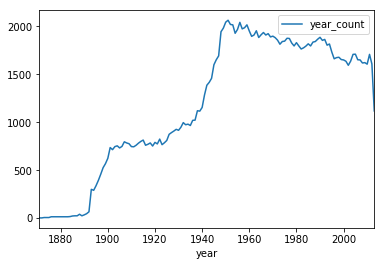

In [24]:
# Convert spark df to pandas df for plotting
yc_pd_df = year_counts_df.toPandas()
yc_pd_df.plot('year','year_count')

### Load data selectively

In [25]:
# Read file using sql query
data_file_city = './data/weather/NY'
query = """
SELECT year,station,measurement
FROM parquet.`%s.parquet`
WHERE measurement=\"SNOW\"
"""%(data_file_city)
df2 = sqc.sql(query)
print(type(df2))
df2.show(5)
df2.count(), df2.columns

<class 'pyspark.sql.dataframe.DataFrame'>
+----+-----------+-----------+
|year|    station|measurement|
+----+-----------+-----------+
|1932|USC00308600|       SNOW|
|1956|USC00308600|       SNOW|
|1957|USC00308600|       SNOW|
|1958|USC00308600|       SNOW|
|1959|USC00308600|       SNOW|
+----+-----------+-----------+
only showing top 5 rows



(15629, ['year', 'station', 'measurement'])